In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import os, sys

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

#performance metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

from data_loader import import_data

In [2]:
data_name = 'sample'
data_x, data_y, y_type = import_data(data_name = data_name)

In [3]:
data_x.shape

(1346, 23, 35)

In [4]:
"""
This function computes the EROS pairwise PCA-based similarity matrix
input myData: Array of matrices (array of multivariate timeseries)
output dist: Pairwise similarity matrix
        [
        [1       x01     x02]
        [x01     1       x12]
        [x02     x12     1  ]
        ]
Citation:
Kiyoung Yang and Cyrus Shahabi, A PCA-based Similarity Measure for Multivariate Time Series, The Second ACM International Workshop on Multimedia Databases (ACM-MMDB 2004), pp 65 - 74 , ISBN:1-58113-975-6, Washington D.C., U.S.A., November 2004
"""

import numpy as np

"""
Compute eigen values and eigen vectors of a matrix
"""
def pca(data):
    # data-centering
    data -= data.mean(axis=0)

    # covariance matrix
    R = np.cov(data, rowvar=False)

    # get eigen vectors and eigen values from the covariance matrix R
    evals, evecs = np.linalg.eigh(R)
    return evals, evecs

"""
Normalizaing eigen values in the eigen value matrix
"""
def normalizeEvals(evals):
    for i in range(0, len(evals)):
        for j in range(0, len(evals[i])):
            evals[i][j] = evals[i][j] / sum(evals[i])
    return evals


"""
compute weight vector from eigen values
"""
def weight_vector(evals):
    weight = []

    # compute mean of each column/variable
    for j in range(0, len(evals[0])):
        mean_val = np.mean(list(map(float, [evals[i][j] for i in range(0, len(evals))])))
        weight.append(mean_val)

    # normalize weight vector
    total_weight = sum(weight)
    normed_weight_vector = [float(i) / total_weight for i in weight]
    return normed_weight_vector


"""
compute the eros pairwise similarity of an array of matrices
"""
def eros(data):
    # compute eigen values and vectors for each matrix
    evals, evecs = [], []
    for i in range(0, len(data)):
        _vals, _vecs = pca(data[i])
        evals.append(_vals)
        evecs.append(np.matrix(_vecs))

    # normalize eigen value to compute weight vector (optional)
    # normEvals = evals
    # normalize eigen value
    # normEvals = normalizeEvals(evals)

    # compute weight vector (defined in the paper)
    w = weight_vector(evals)

    """
    compute pairwise SIMILARITY matrix
    """
    # init similarity matrix
    sim_matrix = np.matrix(np.zeros(shape=(len(evecs), len(evecs), 1)))

    for i in range(0, len(evecs)):
        for j in range(0, len(evecs)):
            if i == j:
                sim_matrix[i, j] = 1
                continue
            if j < i:
                sim_matrix[i, j] = sim_matrix[j, i]
                continue
            # compute pairwise similarity between evecs[i] and evecs[j]
            sim_matrix[i, j] = np.sum([float(
                w[n] * np.abs(np.inner(np.squeeze(np.asarray(evecs[i][:, n])), np.squeeze(np.asarray(evecs[j][:, n])))))
                                       for n in range(0, len(evecs[i]))])
    return (sim_matrix)

In [5]:
m = eros(data_x)

In [ ]:
data_x.dtype

In [6]:
m_df = pd.DataFrame(m)

In [7]:
m_df

,0,1,2,3,4,5,6,7,8,9,...,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345
0,1.000000,0.076432,0.236770,0.118802,0.357140,0.226768,0.169428,0.293089,0.369490,0.295794,...,0.311121,0.174682,0.208050,0.077447,0.229271,0.317118,0.440057,0.054616,0.162237,0.582995
1,0.076432,1.000000,0.099418,0.149794,0.142013,0.663405,0.154893,0.070567,0.101626,0.121801,...,0.242973,0.069109,0.128461,0.144457,0.092937,0.092006,0.110541,0.142944,0.077504,0.097644
2,0.236770,0.099418,1.000000,0.090048,0.183081,0.272695,0.159142,0.158009,0.126708,0.086049,...,0.145640,0.051598,0.053231,0.060389,0.074692,0.051479,0.086882,0.258283,0.229352,0.461172
3,0.118802,0.149794,0.090048,1.000000,0.061650,0.071167,0.099464,0.058838,0.120058,0.271672,...,0.370450,0.088733,0.181699,0.236890,0.543705,0.427662,0.229056,0.386231,0.079753,0.337519
4,0.357140,0.142013,0.183081,0.061650,1.000000,0.189060,0.334592,0.105518,0.319605,0.208801,...,0.512058,0.131334,0.371157,0.208884,0.238434,0.441908,0.159453,0.011927,0.140537,0.341346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,0.317118,0.092006,0.051479,0.427662,0.441908,0.028708,0.057203,0.141378,0.163978,0.222567,...,0.692238,0.137824,0.221155,0.206656,0.334447,1.000000,0.380543,0.318970,0.069288,0.134194
1342,0.440057,0.110541,0.086882,0.229056,0.159453,0.169947,0.196690,0.278603,0.301308,0.141571,...,0.298639,0.208140,0.479992,0.219912,0.226006,0.380543,1.000000,0.071062,0.312462,0.107735
1343,0.054616,0.142944,0.258283,0.386231,0.011927,0.154555,0.067104,0.159595,0.451005,0.319836,...,0.326139,0.243073,0.184617,0.154029,0.237651,0.318970,0.071062,1.000000,0.259964,0.322643
1344,0.162237,0.077504,0.229352,0.079753,0.140537,0.045514,0.122368,0.177418,0.112706,0.088857,...,0.080469,0.121165,0.130065,0.061733,0.170165,0.069288,0.312462,0.259964,1.000000,0.158813


In [21]:
m_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345
count,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,...,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000
mean,0.247662,0.124277,0.233479,0.327027,0.236610,0.182571,0.217824,0.175891,0.248584,0.234797,...,0.223798,0.116827,0.250855,0.190885,0.276248,0.270512,0.272578,0.230540,0.158514,0.282502
std,0.149907,0.112606,0.138787,0.179449,0.150795,0.126547,0.134234,0.127910,0.145287,0.138544,...,0.141327,0.083028,0.147375,0.130327,0.158344,0.156871,0.157928,0.148332,0.121906,0.178887
min,0.016344,0.010231,0.011390,0.008823,0.011927,0.016383,0.016062,0.012383,0.017044,0.009429,...,0.014219,0.007535,0.010626,0.005213,0.012114,0.008818,0.019290,0.003356,0.004463,0.014205
25%,0.128256,0.065868,0.121809,0.175327,0.117935,0.094439,0.115682,0.092173,0.132910,0.128349,...,0.113128,0.068888,0.130193,0.102813,0.145117,0.141336,0.144271,0.115854,0.075423,0.136634
50%,0.218700,0.099441,0.210568,0.311808,0.207567,0.154137,0.189438,0.148389,0.224833,0.219345,...,0.191471,0.102333,0.229650,0.169347,0.255895,0.258482,0.249770,0.206812,0.127095,0.250912
75%,0.338664,0.149257,0.322446,0.464467,0.324451,0.236414,0.292951,0.218712,0.336038,0.314450,...,0.305564,0.147016,0.357882,0.246145,0.388496,0.384917,0.380563,0.313918,0.202110,0.409023
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m_df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
#print(sse)

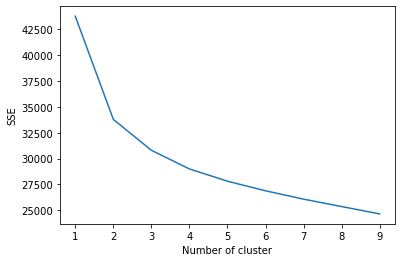

In [10]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [18]:
kmc_cl = KMeans(n_clusters=3)
labels=kmc_cl.fit_predict(m_df)

In [19]:
from sklearn import metrics
print(metrics.silhouette_score(m_df, labels))#, metric='precomputed'))

0.16226345129470715
